<a href="https://colab.research.google.com/github/LucianaNieto/Cambodia_2023/blob/main/3_2_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Image classification with Tensorflow

In this project, I will build a basic classification model to accurately predict satelite data.

My main goals for this project were:

* Learn how to prepare data for Tensorflow ImageDataGenerator
* Understand the workings of 'flow_from_directory'
* Visualise the workings of the classification model
* Maximize accuracy

Start by importing relevant libraries used in this project

In [ ]:
import io
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
import seaborn

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


List all the classes from the directories

In [ ]:
data_dir = '/content/drive/MyDrive/prelims/Data'
labels = [f for f in os.listdir(data_dir) if f != '.DS_Store']
print(labels)


['Burn', 'NoCrop', 'Mixed', 'Vegetation']


Find out the number of images in each category

In [ ]:
for label in labels:
    print(label, len(os.listdir(data_dir+'/'+label)))

Burn 397
NoCrop 2620
Mixed 1819
Vegetation 878


View an example image from each class using Matplotlib

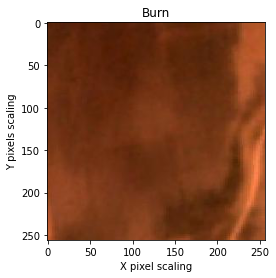

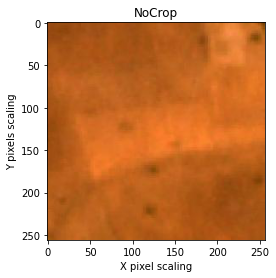

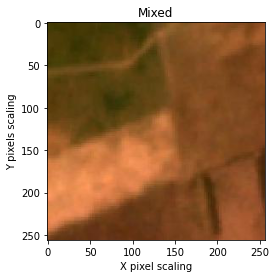

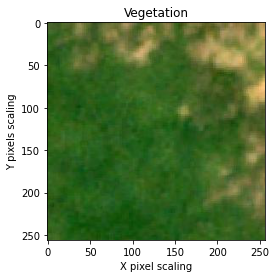

In [ ]:
for label in labels:
    path = os.listdir(data_dir + '/' + label)
    img = data_dir + '/' + label + '/' + path[1]
    plt.title(label)
    plt.xlabel("X pixel scaling")
    plt.ylabel("Y pixels scaling")
    image = mpimg.imread(img)
    plt.imshow(image)
    plt.show()

Create a data generator for test and training sets with a range of data augmentation options. Rescale the images.Split the data into an 80/20 split training and test sets.

In [ ]:
# create a data generator for image augmentation
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,
        rescale=1./255,#scale images
        validation_split=0.2) #split data

#create training set from folders
train_data=datagen.flow_from_directory(data_dir,
                                       target_size=(64,64),
                                       batch_size=32,
                                       class_mode='categorical',
                                       shuffle=True,subset='training')

#create test set
test_data=datagen.flow_from_directory(data_dir,
                                       target_size=(64,64),
                                       batch_size=1,
                                       shuffle=False,subset='validation')

Found 4571 images belonging to 4 classes.
Found 1140 images belonging to 4 classes.


Show some of the images created from the generator

Found 5711 images belonging to 4 classes.


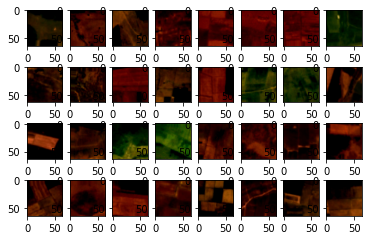

In [ ]:
#sample images
img_iter = datagen.flow_from_directory(data_dir,
                                       target_size=(64,64),
                                       batch_size=32)
x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(32):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

Create a model with different layers, taking an input of (64,64,3) size image and output probabilities using Softmax

In [ ]:
#create a model

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(64,64, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=4, activation="softmax"))

Create the loss function and metrics to be tracked

In [ ]:
# Set the loss function and metrics
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

Create an early stopping callback that will stop if the validation loss doesnt change after 3 epochs.

Fit the model and run for 20 epochs

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=20, 
                    callbacks=[callback])

Epoch 1/20
143/143 [==============================] - 2057s 14s/step - loss: 0.7044 - accuracy: 0.8528 - val_loss: 3.2591 - val_accuracy: 0.3561
Epoch 2/20
143/143 [==============================] - 109s 762ms/step - loss: 0.3031 - accuracy: 0.9147 - val_loss: 1.9440 - val_accuracy: 0.4956
Epoch 3/20
143/143 [==============================] - 107s 751ms/step - loss: 0.2702 - accuracy: 0.9184 - val_loss: 1.4474 - val_accuracy: 0.5912
Epoch 4/20
143/143 [==============================] - 110s 767ms/step - loss: 0.2283 - accuracy: 0.9269 - val_loss: 0.9268 - val_accuracy: 0.6825
Epoch 5/20
143/143 [==============================] - 111s 776ms/step - loss: 0.2162 - accuracy: 0.9271 - val_loss: 1.0922 - val_accuracy: 0.6982
Epoch 6/20
143/143 [==============================] - 111s 777ms/step - loss: 0.2045 - accuracy: 0.9331 - val_loss: 1.7839 - val_accuracy: 0.6693
Epoch 7/20
143/143 [==============================] - 111s 775ms/step - loss: 0.2098 - accuracy: 0.9324 - val_loss: 2.2885 - 

Check the keys in the dictionary output from the model fitting

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Create plots to show the accuracy and loss curves of the training session.

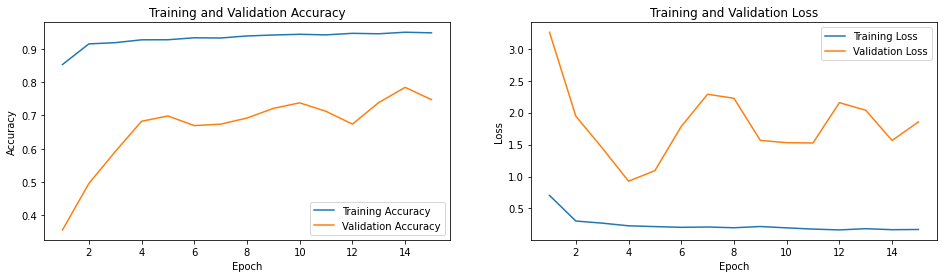

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluate the test data

In [ ]:
score = model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1140/1140 [==============================] - 13s 11ms/step - loss: 1.8416 - accuracy: 0.7544
Test loss: 1.8416227102279663
Test accuracy: 0.7543859481811523


Do a prediction on the test data

In [ ]:
predict=model.predict(test_data)
# predict the class label
y_classes = predict.argmax(axis=-1)
y_classes

1140/1140 [==============================] - 15s 13ms/step


array([0, 0, 2, ..., 3, 1, 3])

Create a confusion matrix

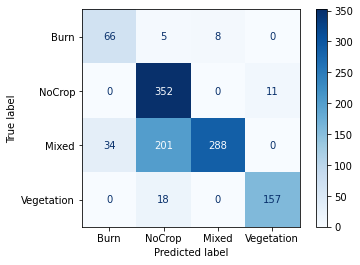

In [ ]:
cm = confusion_matrix(test_data.classes, y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)


disp.plot(cmap=plt.cm.Blues)
plt.show();

Create a classification report to check various metrics

In [ ]:
print(classification_report(test_data.classes, y_classes))


              precision    recall  f1-score   support

           0       0.66      0.84      0.74        79
           1       0.61      0.97      0.75       363
           2       0.97      0.55      0.70       523
           3       0.93      0.90      0.92       175

    accuracy                           0.76      1140
   macro avg       0.79      0.81      0.78      1140
weighted avg       0.83      0.76      0.75      1140



The model can be improved by experimenting with hyperparameters and adding/subtracting layers.